# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [11]:
def P1(num_examples=5):
    #loop over training data for the number of examples we want
    for i in range(num_examples):
        ex_num = i+1
        ex_text = train_data[i]
        ex_label = newsgroups_train.target_names[train_labels[i]]
        print('Example #%i:\nMessage Text:\n%s\nMessage Label: %s\n'%(ex_num,ex_text,ex_label))
P1()

Example #1:
Message Text:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Message Label: comp.graphics

Example #2:
Message Text:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corru

### Part 2:

Transform the training data into a matrix of word unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method.

Now transform the training data into a matrix of word unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
Use `CountVectorization(vocabulary=...)` and its `.transform` method.

Now transform the training data into a matrix of character bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method.

Now transform the training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
Use `CountVectorization(min_df=...)` and its `.fit_transform` method.

Now again transform the training data into a matrix of word unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
Hint: Build vocabularies for both train and dev and look at the size of the difference.

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [12]:
def P2():
    #Part a)
    #initialize vecotrizer
    cvt = CountVectorizer()
    cvt_train = cvt.fit_transform(train_data)
    #get vocab size
    vocab_size = len(cvt.vocabulary_)
    #calc avg non-zero features and total fraction non-zero
    avg_nnz = np.mean([i.nnz for i in cvt_train])
    frac_nz = cvt_train.nnz/(cvt_train.shape[0]*vocab_size)
    print('a)\nVocabulary Size: %i\nAverage non-zero features per example: %f\nTotal Non-Zero Fraction: %f\n'%(vocab_size,avg_nnz,frac_nz))
    
    #Part b)
    #extract feature names
    feature_names = cvt.get_feature_names()
    #get first and last feature names
    print('b)\n0th Feature: %s\nLast Feature: %s\n'%(feature_names[0],feature_names[-1]))
    
    #Part c)
    #initialize vectorizer with limited vocab
    vocab = {'atheism': 0, 'graphics' : 1, 'space' : 2, 'religion' : 3}
    lv_cv = CountVectorizer(vocabulary = vocab)
    lv_cv_train = lv_cv.transform(train_data)
    #get shape of transformed data
    shape_lv_cv_train = lv_cv_train.shape
    #get avg non zero features
    lv_cv_avg_nnz = np.mean([i.nnz for i in lv_cv_train])
    print('c)\nNumber of Training Examples: %i\nLength of New Vocabulary: %i\nAverage non-zero features per example: %f\n'%(shape_lv_cv_train[0],shape_lv_cv_train[1],lv_cv_avg_nnz))
    
    #Part d)
    #use a vectorizer for bi and tri-grams based on characters
    cng_cv = CountVectorizer(analyzer = 'char', ngram_range = (2,3))
    cng_cv_train = cng_cv.fit_transform(train_data)
    cng_cv_vocab_size = len(cng_cv.vocabulary_)
    print('d)\nVocabulary Size Using Character bi- and tri-grams: %i\n'%cng_cv_vocab_size)
    
    #Part e)
    #use vectorizer with words that occur only in 10 docs
    prune_cv = CountVectorizer(min_df = 10)
    prune_cv_train = prune_cv.fit_transform(train_data)
    prune_cv_vocab_size = len(prune_cv.vocabulary_)
    print('e)\nPruned Vocabulary Size: %i\n'%prune_cv_vocab_size)
    
    #Part f)
    train_vocab = list(cvt.vocabulary_.keys())
    #initialize and fit a CountVectorizer for the dev data
    cvd = CountVectorizer()
    cvd_train = cvd.fit_transform(dev_data)
    dev_vocab = list(cvd.vocabulary_.keys())
    dev_vocab_size = len(dev_vocab)
    num_missing_words = np.sum([1 if word not in train_vocab else 0 for word in dev_vocab])
    #vocab_difference = np.setdiff1d(train_vocab,dev_vocab)
    #num_missing_vocab = len(vocab_difference)
    missing_frac = num_missing_words/dev_vocab_size
    print('f)\nFraction of dev_data vocab missing from train_data: %f'%missing_frac)

    
P2()

a)
Vocabulary Size: 26879
Average non-zero features per example: 96.705998
Total Non-Zero Fraction: 0.003598

b)
0th Feature: 00
Last Feature: zyxel

c)
Number of Training Examples: 2034
Length of New Vocabulary: 4
Average non-zero features per example: 0.268437

d)
Vocabulary Size Using Character bi- and tri-grams: 35478

e)
Pruned Vocabulary Size: 3064

f)
Fraction of dev_data vocab missing from train_data: 0.247876


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def P3():

    cv = CountVectorizer()
    train_vec = cv.fit_transform(train_data)
    dev_vec = cv.transform(dev_data)
    
    #Part 1:
    print('---------- K-NN Models ----------')
    #Choosing a range of k_values 1-10 inclusive
    k_values = np.arange(1,11,1)
    max_f1 = 0
    best_k = 0
    #iterate over each k value to train and test a KNN model for each k. Prints results of each k
    for k in k_values:
        #classifier set up
        knn_cls = KNeighborsClassifier(n_neighbors = k)
        trained_knn = knn_cls.fit(train_vec,train_labels)
        
        #metrics
        predictions = trained_knn.predict(dev_vec)
        f1 = metrics.f1_score(dev_labels,predictions,average="weighted")
        
        #report results
        print("KNN Classifier with k = %i has a F1 score of: %.3f"%(k,f1))
        #for finding optimal k based on f1 score
        if f1 > max_f1:
            max_f1 = f1
            best_k = k
    #report optimal k
    print("The best F1 score for k = 1-10 is %.3f for k = %i.\n"%(max_f1,best_k))
    
    #Part 2:
    print('---------- Naive Bayes Models ----------')
    #alpha values to try
    alphas = [0.001,0.01,0.1,1,5,10,20,50,100]
    max_f1 = 0
    best_alpha = -1
    for a in alphas:
        #classifier set up
        nb_cls = MultinomialNB(alpha = a)
        trained_nb = nb_cls.fit(train_vec,train_labels)
        
        #metrics
        predictions = trained_nb.predict(dev_vec)
        f1 = metrics.f1_score(dev_labels,predictions,average="weighted")
        #report results
        print("Naive Bayes Classifier with alpha = %.3f has a F1 score of: %.3f"%(a,f1))
        #for finding optimal alpha based on f1 score
        if f1 > max_f1:
            max_f1 = f1
            best_alpha = a
    #report optimal alpha
    print("The best F1 score is %.3f for alpha = %.3f.\n"%(max_f1,best_alpha))
    
    #Part 3:
    print('---------- Logistic Regression Models ----------')
    #alpha values to try
    L2_regs = [0.001,0.01,0.1,0.5,1,5,10,20,50,100]
    max_f1 = 0
    best_L2 = -1
    for l in L2_regs:
        #classifier set up
        lr_cls = LogisticRegression(C=l, solver="liblinear", multi_class="auto")
        trained_lr = lr_cls.fit(train_vec,train_labels)
        
        #metrics
        accuracy = trained_lr.score(dev_vec,dev_labels)
        predictions = trained_lr.predict(dev_vec)
        f1 = metrics.f1_score(dev_labels,predictions,average="weighted")
        sum_sq_weights = np.sum((trained_lr.coef_)**2)
        #report results
        print("Logistic Regression Classifier with C = %.3f has a F1 score of: %.3f and a sum of squared weights of: %.3f"%(l,f1,sum_sq_weights))
        #for finding optimal alpha based on f1 score
        if f1 > max_f1:
            max_f1 = f1
            best_L2 = l
    #report optimal L2 regularlization parameter
    print("The best F1 score is %.3f for C = %.3f.\n"%(max_f1,best_L2))
P3()

---------- K-NN Models ----------
KNN Classifier with k = 1 has a F1 score of: 0.381
KNN Classifier with k = 2 has a F1 score of: 0.381
KNN Classifier with k = 3 has a F1 score of: 0.408
KNN Classifier with k = 4 has a F1 score of: 0.403
KNN Classifier with k = 5 has a F1 score of: 0.429
KNN Classifier with k = 6 has a F1 score of: 0.447
KNN Classifier with k = 7 has a F1 score of: 0.450
KNN Classifier with k = 8 has a F1 score of: 0.447
KNN Classifier with k = 9 has a F1 score of: 0.437
KNN Classifier with k = 10 has a F1 score of: 0.428
The best F1 score for k = 1-10 is 0.450 for k = 7.

---------- Naive Bayes Models ----------
Naive Bayes Classifier with alpha = 0.001 has a F1 score of: 0.770
Naive Bayes Classifier with alpha = 0.010 has a F1 score of: 0.775
Naive Bayes Classifier with alpha = 0.100 has a F1 score of: 0.790
Naive Bayes Classifier with alpha = 1.000 has a F1 score of: 0.778
Naive Bayes Classifier with alpha = 5.000 has a F1 score of: 0.723
Naive Bayes Classifier with

ANSWER:  
**Question 4:** Why doesn't k-Nearest Neighbors work well for this problem?  
k-Nearest Neighbors has difficulties with data with many dimensions. In this context of classifying documents using a large vocabulary (28,879 words), training points tend to be very far from each other, making the similarity between documents vague. 
  
**Question 5:** Why doesn't Logistic Regression work as well as Naive Bayes does?  
Logistic regression is capturing the increase in odds of a document belonging to a certain class based on unit increases in the count of specific words in the vocabulary. In contrast, Naive Bayes is looking at the posterior probabilities of each class given the counts of words directly. In my interpretation, this transfers more fluently to the problem given the size of the vocabulary. Because of the size of the vocabulary, there is necessarily 28,880 coefficients (vocab size + 1 for the intercept), which are collectively very small and individually do not contribute much to classification.  
  
**Question 6:** What is the relationship between logistic regression's sum of squared weights vs. C value?  
Regularization helps shrink weights that are too large. The larger the C value, the smaller the amount of regularization that goes into the model. With less regularization, the weights tend to be larger, boosting the value of the sum of squared weights.

### Part 4:  
Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value.

In [6]:
def P4():
    #initialize a CountVectorizer
    cv = CountVectorizer(ngram_range=(2, 2))
    train_cv = cv.fit_transform(train_data)
    
    #train a logistic regression model.
    lr_cls = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    trained_lr = lr_cls.fit(train_cv,train_labels)
    
    #report number of bigram features
    feature_names = cv.get_feature_names()
    print('There are %i bigram word features.'%len(feature_names))
    
    #get the indices for the top 5 features in each class/category
    top_indices = np.array([],dtype=int)
    for cls in trained_lr.coef_:
        ind = cls.argsort()[-5:][::-1] #np.argpartition(cls, -5)[-5:]
        top_indices = np.append(top_indices,ind)
    
    #populate a dictionary of the top features and the weights for those features for each class
    top_features = {}
    for ti in top_indices:
        feature = feature_names[ti]
        top_features[feature] = []
        for i in range(4):
            top_features[feature].append(trained_lr.coef_[i][ti])
    
    #Print out the markdown for the table of features and their weights for each category
    #This ouput is pasted into markdown cells below for easy viewing.
    print('| word (row)/category(col) | %s | %s | %s | %s |'%(newsgroups_train.target_names[0],newsgroups_train.target_names[1],newsgroups_train.target_names[2],newsgroups_train.target_names[3]))
    print('|:---:|:---:|:---:|:---:|:---:|')
    for feature, weights in top_features.items():
        print('| %s | %.2f | %.2f | %.2f | %.2f |'%(feature, weights[0], weights[1], weights [2], weights[3]))
    
P4()

There are 194891 bigram word features.
| word (row)/category(col) | alt.atheism | comp.graphics | sci.space | talk.religion.misc |
|:---:|:---:|:---:|:---:|:---:|
| claim that | 0.61 | -0.20 | -0.27 | -0.14 |
| cheers kent | 0.56 | -0.70 | -0.66 | 0.53 |
| was just | 0.48 | -0.13 | -0.13 | -0.23 |
| you are | 0.47 | -0.28 | -0.48 | 0.03 |
| are you | 0.45 | -0.25 | -0.10 | -0.31 |
| looking for | -0.63 | 1.11 | -0.50 | -0.57 |
| in advance | -0.46 | 0.83 | -0.44 | -0.42 |
| comp graphics | -0.29 | 0.80 | -0.37 | -0.29 |
| out there | -0.27 | 0.76 | -0.48 | -0.28 |
| is there | -0.34 | 0.75 | -0.47 | -0.26 |
| the space | -0.27 | -0.53 | 0.87 | -0.27 |
| the moon | -0.35 | -0.49 | 0.83 | -0.21 |
| sci space | -0.26 | -0.33 | 0.62 | -0.22 |
| and such | -0.20 | -0.34 | 0.59 | -0.22 |
| it was | -0.20 | -0.31 | 0.53 | -0.31 |
| the fbi | -0.13 | -0.21 | -0.30 | 0.55 |
| ignorance is | -0.16 | -0.17 | -0.14 | 0.50 |
| but he | -0.19 | -0.22 | -0.14 | 0.49 |
| of jesus | -0.09 | -0.17 | -0.

ANSWER:  
Table of top features and their weights in each category:

| word (row)/category(col) | alt.atheism | comp.graphics | sci.space | talk.religion.misc |
|:---:|:---:|:---:|:---:|:---:|
| claim that | 0.61 | -0.20 | -0.27 | -0.14 |
| cheers kent | 0.56 | -0.70 | -0.66 | 0.53 |
| was just | 0.48 | -0.13 | -0.13 | -0.23 |
| you are | 0.47 | -0.28 | -0.48 | 0.03 |
| are you | 0.45 | -0.25 | -0.10 | -0.31 |
| looking for | -0.63 | 1.11 | -0.50 | -0.57 |
| in advance | -0.46 | 0.83 | -0.44 | -0.42 |
| comp graphics | -0.29 | 0.80 | -0.37 | -0.29 |
| out there | -0.27 | 0.76 | -0.48 | -0.28 |
| is there | -0.34 | 0.75 | -0.47 | -0.26 |
| the space | -0.27 | -0.53 | 0.87 | -0.27 |
| the moon | -0.35 | -0.49 | 0.83 | -0.21 |
| sci space | -0.26 | -0.33 | 0.62 | -0.22 |
| and such | -0.20 | -0.34 | 0.59 | -0.22 |
| it was | -0.20 | -0.31 | 0.53 | -0.31 |
| the fbi | -0.13 | -0.21 | -0.30 | 0.55 |
| cheers kent | 0.56 | -0.70 | -0.66 | 0.53 |
| ignorance is | -0.16 | -0.17 | -0.14 | 0.50 |
| but he | -0.19 | -0.22 | -0.14 | 0.49 |
| of jesus | -0.09 | -0.17 | -0.21 | 0.42 |

There are a lot of surprising bigrams in the table: "are you," "you are," "is there," "it was," and "and such" are a few that I would name. These suprise me because they seem like they would be very common phrases that are not particular to a specific topic. I would expect phrases like that to have weights closer to zero for all categories. Instead, they are some of the highest weights in these categories.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [7]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    #lowercase the string
    s = s.lower()
    #substitute new line characters for spaces
    s = re.sub('[\n]+',' ',s)
    #replace sequences of numbers with a single 'X'
    s = re.sub('[0-9]+','X',s)
    #allow all lower case letters, certain symbols, and 'X' to remain in the string
    #characters not in this set are removed 
    s = re.sub('[^a-z)(&X=<> ]+', '', s)
    
    #get sequences of characters in s split by spaces
    sequences = s.split(' ')
    updated_sequences = []
    #set a length threshold for words to include
    length_threshold = 6
    #iterate over sequences and shorten everything at the threshold or longer to the number of threshold characters
    for seq in sequences:
        if len(seq) < length_threshold:
            updated_sequences.append(seq)
        else:
            updated_sequences.append(seq[0:length_threshold])
            
    s = ' '.join(updated_sequences)
    return s

def P5():

    #initialize a CountVectorizer with empty pre-processor
    cv_npp = CountVectorizer(preprocessor=empty_preprocessor)
    train_vec_npp = cv_npp.fit_transform(train_data)
    dev_vec_npp = cv_npp.transform(dev_data)
    
    #report vocab size
    vocab_npp = cv_npp.vocabulary_.keys()
    print('Size of vocabulary (raw data): %i'%len(vocab_npp))
    
    #set up a logistic regression model for the raw data
    lr_npp = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    trained_lr_npp = lr_npp.fit(train_vec_npp,train_labels)
    
    predictions_npp = trained_lr_npp.predict(dev_vec_npp)
    f1_npp = metrics.f1_score(dev_labels,predictions_npp,average="weighted")
    print('The F1 score for the raw text data is: %.4f\n'%f1_npp)

    #initialize a new CountVectorizer with better preprocessor
    cv_pp = CountVectorizer(preprocessor=better_preprocessor)
    train_vec_pp = cv_pp.fit_transform(train_data)
    dev_vec_pp = cv_pp.transform(dev_data)
    
    #report vocab size
    vocab_pp = cv_pp.vocabulary_.keys()
    print('Size of vocabulary (pre-processed data): %i'%len(vocab_pp))
    
    #set up a logistic regression model for the pre-processed data
    lr_pp = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    trained_lr_pp = lr_pp.fit(train_vec_pp,train_labels)
    
    predictions_pp = trained_lr_pp.predict(dev_vec_pp)
    f1_pp = metrics.f1_score(dev_labels,predictions_pp,average="weighted")
    print('The F1 score for the pre-processed text data is: %.4f\n'%f1_pp)
    
    print('The vocabulary was reduced in size by %i words by pre-processing the data.'%(len(vocab_npp) - len(vocab_pp)))
    
P5()

Size of vocabulary (raw data): 33291
The F1 score for the raw text data is: 0.7069

Size of vocabulary (pre-processed data): 19695
The F1 score for the pre-processed text data is: 0.7230

The vocabulary was reduced in size by 13596 words by pre-processing the data.


### Part 6:


The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

Baseline Model with L2 Regularization - C = 0.5 - Tolerance = 0.015
Baseline vocabulary Size: 26879
Baseline F1: 0.697


/Users/nick/.venvs/W207/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Inverse Regularization Strength C = 0.005, Vocab Size: 12, L2 F1 Score: 0.137
Inverse Regularization Strength C = 0.01, Vocab Size: 17, L2 F1 Score: 0.137
Inverse Regularization Strength C = 0.1, Vocab Size: 216, L2 F1 Score: 0.187
Inverse Regularization Strength C = 0.5, Vocab Size: 775, L2 F1 Score: 0.345
Inverse Regularization Strength C = 1, Vocab Size: 1094, L2 F1 Score: 0.411
Inverse Regularization Strength C = 5, Vocab Size: 2473, L2 F1 Score: 0.496
Inverse Regularization Strength C = 10, Vocab Size: 3498, L2 F1 Score: 0.522
Inverse Regularization Strength C = 50, Vocab Size: 6022, L2 F1 Score: 0.582
Inverse Regularization Strength C = 100, Vocab Size: 7813, L2 F1 Score: 0.587
Inverse Regularization Strength C = 250, Vocab Size: 17631, L2 F1 Score: 0.677
Inverse Regularization Strength C = 1000, Vocab Size: 25457, L2 F1 Score: 0.681
Inverse Regularization Strength C = 2500, Vocab Size: 26663, L2 F1 Score: 0.689
Inverse Regularization Strength C = 5000, Vocab Size: 26802, L2 F1 S

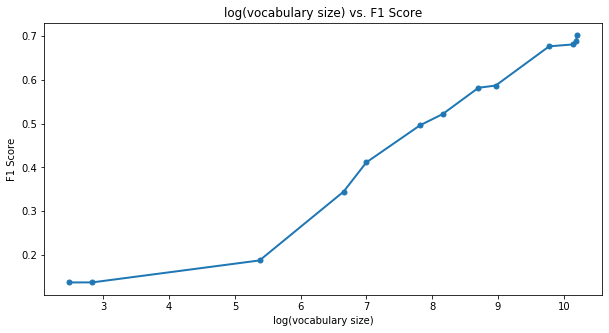

In [8]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    #using common vocab, vectorize train and dev data
    cv = CountVectorizer()#vocabulary = init_common_vocab)
    train_data_vec = cv.fit_transform(train_data)
    dev_data_vec = cv.transform(dev_data)
    
    baseline_lr = LogisticRegression(C = 0.5, penalty = 'l2', solver= 'liblinear', multi_class = 'auto', tol = 0.015)
    trained_baseline_lr = baseline_lr.fit(train_data_vec,train_labels)
    baseline_predictions = trained_baseline_lr.predict(dev_data_vec)
    baseline_f1 = metrics.f1_score(dev_labels,baseline_predictions, average = 'weighted')
    print('Baseline Model with L2 Regularization - C = 0.5 - Tolerance = 0.015')
    print('Baseline vocabulary Size: %i'%len(cv.vocabulary_.keys()))
    print('Baseline F1: %.3f'%baseline_f1)
    
    L1_strengths = [0.005,0.01,0.1,0.5,1,5, 10,50, 100,250, 1000,2500,5000]
    vocab_sizes = []
    f1_scores = []
    for L1 in L1_strengths:
        # Keep this random seed here to make comparison easier.
        # Added the random seed again because results were unstable between iterations
        np.random.seed(0)
        #train a logistic regression model with L1 regularization
        L1_lr = LogisticRegression(C = L1, penalty = "l1", tol = 0.015, solver= 'liblinear', multi_class = 'auto')
        trained_L1_lr = L1_lr.fit(train_data_vec, train_labels)
        
        #find unique non-zero indices and coerce to array
        non_zero_indices = np.array(list(set(np.nonzero(trained_L1_lr.coef_)[1])))
        
        #reduced vocabulary is the common vocabulary filtered to the indices for non-zero weights
        reduced_vocab = np.array(list(cv.vocabulary_.keys()))[non_zero_indices]
        reduced_vocab_size = len(reduced_vocab)
        vocab_sizes.append(reduced_vocab_size)
        
        #set up new vectorizer with reduced vocab and transform train and dev sets
        reduced_cv = CountVectorizer(vocabulary=reduced_vocab)
        red_train_data = reduced_cv.fit_transform(train_data)
        red_dev_data = reduced_cv.transform(dev_data)
        
        #set up and train a logistic regression model with L2 regularization
        L2_lr = LogisticRegression(C = 0.5, penalty = 'l2', solver= 'liblinear', multi_class = 'auto', tol = 0.015)
        trained_L2_lr = L2_lr.fit(red_train_data,train_labels)
        predictions = trained_L2_lr.predict(red_dev_data)
        f1 = metrics.f1_score(dev_labels,predictions, average = 'weighted')
        
        f1_scores.append(f1)
        print('Inverse Regularization Strength C = %s, Vocab Size: %i, L2 F1 Score: %.3f'%(L1,reduced_vocab_size,f1))
    
    #plot the data
    fig = plt.figure(figsize = (10,5))
    plt.plot(np.log(vocab_sizes),f1_scores, marker = '.', markersize = 10, linewidth = 2)
    plt.title('log(vocabulary size) vs. F1 Score')
    plt.xlabel('log(vocabulary size)')
    plt.ylabel('F1 Score')
    plt.show()
    
P6()

ANSWER:  
The baseline model with a full vocabulary (size = 26879) on these data returned an F1 score of 0.697. For the reduced vocabularies, F1 scores were lower the smaller the vocabulary. Very small regularization strengths (high values of C) produced vocabularies near in size to the full vocabulary and produced similar (F1 = 0.689; C = 2500; vocab size = 26663) or higher (F1 = 0.702; C = 5000; vocab size = 28802). Unsurprisingly, extremely high degrees of regularization, e.g., C = 0.005, which produces a regularization strength of 200, limits the vocabulary for the L2 model to such a degree that the model is rendered useless (F1 score: 0.137; vocab size **12 words**). 


### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def P7():
    #initialize vectorizer and transform train and dev data
    tv = TfidfVectorizer()
    train_tv_vec = tv.fit_transform(train_data)
    dev_tv_vec = tv.transform(dev_data)
    
    #set ug logistic regression model and train
    lr = LogisticRegression(C = 100, penalty = 'l2', solver="liblinear", multi_class="auto" )
    trained_lr = lr.fit(train_tv_vec,train_labels)
    
    #make predictions on dev data and report results
    predictions = trained_lr.predict(dev_tv_vec)
    f1 = metrics.f1_score(dev_labels,predictions,average='weighted')
    print('Logistic Regresssion Model with C = 100 and L2 Regularization:\nF1 Score: %.3f\n'%f1)
    
    #get probabilties
    predicted_probabilities = trained_lr.predict_proba(dev_tv_vec)
    
    #calculate R values for each test example
    R_values = []
    for i in range(len(dev_data)):
        correct_label_index = dev_labels[i]
        R = max(predicted_probabilities[i])/predicted_probabilities[i][correct_label_index]
        R_values.append(R)
    
    #find top 3 R values
    R_values = np.array(R_values)
    max_R_indices = R_values.argsort()[-3:][::-1]
    max_R_values = R_values[max_R_indices]
    
    #print top 3 R values and corresponding documents
    for i in range(3):
        R = max_R_values[i]
        pred = newsgroups_train.target_names[predictions[max_R_indices[i]]]
        true = newsgroups_train.target_names[dev_labels[max_R_indices[i]]]
        text = dev_data[max_R_indices[i]]
        print('Rank %i\nR Value: %.2f\nPredicted Label: %s | True Label: %s\nText: %s\n'%(i+1,R,pred, true,text))

P7()

Logistic Regresssion Model with C = 100 and L2 Regularization:
F1 Score: 0.760

Rank 1
R Value: 929.36
Predicted Label: comp.graphics | True Label: talk.religion.misc
Text: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anyth

ANSWER:  
`CountVectorizer` uses counts of words in a given document, essentially how often the words occur, or document term frequency. `TfidfVectorizer` uses a combination of term frequency and inverse document frequency (IDF), which scores words that appear less often higher than words that appear often. For example, "the" is a very common word both in terms of how often it occurs in a document and over many documents. In contrast, the word "erudite" is certainly much less common both in terms of the number of times it would be included in a document and the number of documents it is contained in. Looking at these specific words, a corpus of documents would generate higher TFIDF scores for "erudite" than "the" because "erudite" is less common and seen as more important.  
  
The $R$ value provides a metric for detecting how well the classifier picks up on the correct terms in a document. A perfect score is 1 assuming that the classifer chooses the label based on the maximum probability class. Higher $R$ scores indicate the correct terms relative to a given class are not being used to make the classification because the classfiier assigns a higher probability to the incorrect class. In the context of our three highest $R$ values:  
1. The correct label for the Rank 1 $R$ value (929.36) was talk.religion.misc but the classifier predicted that it would be comp.graphics. Evaluating it as a human reader, this specific example talks a lot about computer-related terms such as FTP, connect, cd pub, ASCII, etc. The example reads as instructions for performing a computer task though the context is all about religion. The classifier picked up on the computer-related words instead of the important, contextual words (Book of Mormon, Joseph Smith Story).
2. The correct label for the Rank 2 $R$ value (325) was talk.religion.misc. Similar to the Rank 1 $R$ value, it was also predicted to be comp.graphics. The content of the text is related to the same subject matter as the Rank 1 R value post: the online text of The Book of Mormon. Key phrases the classifier likely picked up on include: ftp, site, online, email, internet, address.
3. The correct label for the Rank 3 $R$ value (278.18) was alt.atheism but the classifier predicted it would be talk.religion.misc. This entry is only 26 words long and most of the words are relatively neutral (in my human interpretation) when it comes to determining if the post is about religion or atheisim. If provided the same categories for choosing a label for this post, I would be guessing. The post reads more like a news story. It is possible that somewhere in the training data there is a post (or many) relating to some of the key words in this post, killed, fired, gunman, and children, which caused the classifier to assign a much greater probability to religion than atheism.  
  
Relaxing some of the regularization to increase the vocabulary of the model might help fix these issues. Additionally, if there were a way to add contextual information such as part of speech tagging or perhaps topical context information for individual words, the classifier might have an easier time with the confusing cases presented here.

### Part 8 EXTRA CREDIT:

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [10]:
#set seed for better comparison
np.random.seed(0)

#define a preprocessor
def better_preprocessor(s):
    #lowercase the string
    
    #s = s.lower()
    #substitute new line characters for spaces
    s = re.sub('[\n]+',' ',s)
    #replace sequences of numbers with a single 'X'
    s = re.sub('[0-9]+','#',s)
    #allow all lower case letters, certain symbols, and 'X' to remain in the string
    #characters not in this set are removed 
    s = re.sub('[^A-Za-z# ]+', '', s)
    
    #get sequences of characters in s split by spaces
    sequences = s.split(' ')
    updated_sequences = []
    #set a length threshold for words to include
    length_threshold = 5
    #iterate over sequences and shorten everything at the threshold or longer to the number of threshold characters
    for seq in sequences:
        if len(seq) < length_threshold:
            updated_sequences.append(seq)
        else:
            updated_sequences.append(seq[0:length_threshold])
            
    s = ' '.join(updated_sequences)
    return s

#use the tfidf vectorizer on train, dev, and test sets
tv = TfidfVectorizer(preprocessor=better_preprocessor,ngram_range=(1, 2))
train_vec = tv.fit_transform(train_data)
dev_vec = tv.transform(dev_data)
test_vec = tv.transform(test_data)

#improved model
lr = LogisticRegression(C = 1000, penalty = 'l2', solver= 'saga', multi_class = 'auto', tol = 0.01)
baseline = lr.fit(train_vec,train_labels)
baseline_predictions = baseline.predict(dev_vec)

print('---Results: Improved Model on Dev Data---')
#evaluate and report performance
baseline_acc = baseline.score(dev_vec,dev_labels)
baseline_f1 = metrics.f1_score(dev_labels,baseline_predictions,average = 'weighted')
print('Accuracy: %f\nF1: %f'%(baseline_acc,baseline_f1))
print(classification_report(dev_labels,baseline_predictions))

#evaluate on test
test_predictions = baseline.predict(test_vec)
print('---Results: Improved Model on Test Data---')
#evaluate and report performance
test_acc = baseline.score(test_vec,test_labels)
test_f1 = metrics.f1_score(test_labels,test_predictions,average = 'weighted')
print('Accuracy: %f\nF1: %f'%(test_acc,test_f1))
print(classification_report(test_labels,test_predictions))

---Results: Improved Model on Dev Data---
Accuracy: 0.769231
F1: 0.765664
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       165
           1       0.86      0.88      0.87       185
           2       0.77      0.87      0.82       199
           3       0.67      0.61      0.64       127

    accuracy                           0.77       676
   macro avg       0.76      0.75      0.75       676
weighted avg       0.77      0.77      0.77       676

---Results: Improved Model on Test Data---
Accuracy: 0.771049
F1: 0.767128
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       154
           1       0.91      0.89      0.90       204
           2       0.77      0.89      0.82       195
           3       0.69      0.53      0.60       124

    accuracy                           0.77       677
   macro avg       0.75      0.74      0.74       677
weighted avg       0.77      0.77   

Combining strategies from the problems above, I was able to get up to a 76.9% accuracy with an F1 score of 0.766 on dev data and 77.1% accruacy with an F1 score og 0.767 on test data. I utilized a custom preprocessor in attempt to filter out some of the noisy charcter sequences from important words. I also used a TFIDF vectorizer instead of the CountVectorizer because I noticed it performed better on average.